In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.ticker as mtick
from fc_nets import *
from utils import *

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{dsfont}'


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import warnings
warnings.filterwarnings('ignore')
colors = ['lightsteelblue', 'cornflowerblue', 'blue', 'midnightblue', 'green', 'red']
label_size = 23
legend_size = 18
x_log_scale = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


y tensor([-0.2940, -0.6187,  0.6512,  0.4729, -0.7794,  0.8802, -1.1974,  0.0473,
         0.8891,  0.1819,  0.2232,  0.5533,  0.0766, -0.1600,  1.0661,  0.9068,
         1.2501,  0.8880,  1.0038,  0.8947])
batch_size=1, rho=0.00: train loss 5.824353502248414e-05, test loss 0.03987962380051613, l2_param 6.850787720322096, feature rank 18, n nnz neurons 100, n distinct neurons 99
batch_size=1, rho=0.10: train loss 4.5134860556572676e-05, test loss 0.011278560385107994, l2_param 3.7077283615809136, feature rank 18, n nnz neurons 99, n distinct neurons 95
batch_size=1, rho=0.20: train loss 7.04133854014799e-05, test loss 0.02055937610566616, l2_param 3.0497610655201655, feature rank 16, n nnz neurons 94, n distinct neurons 58
batch_size=1, rho=0.30: train loss 0.00019167046411894262, test loss 0.013537483289837837, l2_param 2.8411331712607875, feature rank 12, n nnz neurons 84, n distinct neurons 26
batch_size=1, rho=0.40: train loss 0.0026950878091156483, test loss 0.01429076213389635, l

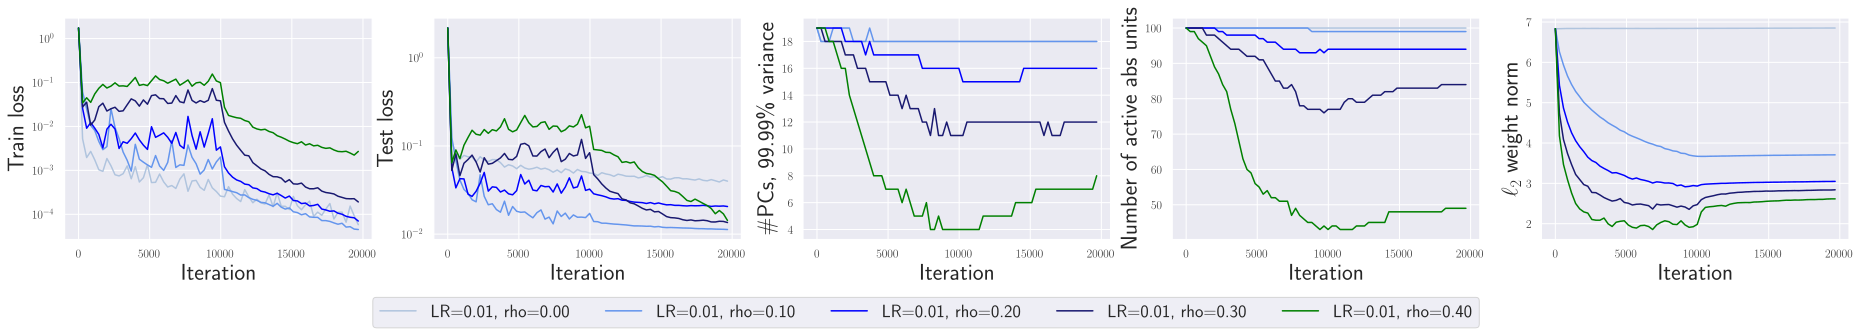

In [118]:
### SGD with abs activation
hps = {
    'lenaic_with_biases_no_alignment': {'n': 20, 'd': 3, 'm_teacher': 3, 'm_student': 100, 'init_scales_teacher': [1.0, 1.0], 'init_scales_student': [0.3, 0.3], 'seed': 4, 'gamma': 0.455, 'warmup_mult_factor': 1.0},
}

exp = 'lenaic_with_biases_no_alignment' 
act = 'abs'
biases = True
X, y, X_test, y_test, net_teacher = get_data_two_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'], biases=biases, act=act)
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.3, x_log_scale=x_log_scale, n_iters_first=1, n_iters_next=71)  # 4.15

n_plots = 5
lp = 0.1
l0_threshold = 0.1
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001
percentile_pcs = 0.9999
nnz_threshold = 0.05

gamma, batch_size = 0.01, 1  # SAM requires lowering the step size a bit
schedule_length, decay_factor = 0.5, 1.0  
rhos = [0.0, 0.1, 0.2, 0.3, 0.4]
rho_duration = schedule_length
sam_grad_normalization = True

nets_all = []
plt.figure(figsize = (32, 4))  # (12, 4) for 2 plots, (22, 4) for 3 plots, (26, 4) for 4 plots, (32, 4) for 5 plots
for i, rho in enumerate(rhos):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet2Layers(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student'], biases=[biases, biases], act=act) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    # train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], iters_percentage_linear_warmup=schedule_length, gamma_warmup_factor_max=2.5*schedule_length, warmup_exponent=1.0) 
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], rho=rho, rho_duration=rho_duration, sam_grad_normalization=sam_grad_normalization) 
    nets_all.append(nets)
    # lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy())[1]**lp).sum() for net in nets]
    lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1]**lp).sum() for net in nets]
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer1.bias.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2) + np.sum(net.layer2.bias.data.numpy()**2))**0.5 for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    feature_ranks = np.array([compute_n_pcs(compute_feature_sing_values(net, X), percentile_pcs) for net in nets])
    n_nnz_acts = [((np.abs(net.features(X)) < nnz_threshold).sum(0) < X.shape[0]).sum() for net in nets]
    n_distinct_acts = [hps[exp]['m_student'] - net.n_highly_corr(X, corr_threshold=0.999) for net in nets]

    print('batch_size={}, rho={:.2f}: train loss {}, test loss {}, l2_param {}, feature rank {}, n nnz neurons {}, n distinct neurons {}'.format(batch_size, rho, train_losses[-1], test_losses[-1], l2_norms[-1], feature_ranks[-1], n_nnz_acts[-1], n_distinct_acts[-1]))

    label = 'LR={:.2f}, rho={:.2f}'.format(gamma, rho)

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, feature_ranks, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('\#PCs, {:.2f}\% variance'.format(percentile_pcs*100), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, n_nnz_acts, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    # plt.ylabel('\# non-zero activations ($>${})'.format(nnz_threshold), fontsize=label_size)
    # plt.ylabel('\# of non-zero activations', fontsize=label_size)
    plt.ylabel('Number of active abs units', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 5)
    plt.plot(iters_loss, l2_norms, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$\ell_2$ weight norm', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.22), ncol=7, prop={'size': legend_size})
plt.savefig("plots/fc_net_d={}_exp={}_lp={}_act={}.pdf".format(hps[exp]['d'], exp, lp, act), bbox_inches='tight')
plt.show()

y tensor([-0.2549, -0.5297, -0.0633,  0.1160, -0.3664, -0.6477, -0.4813, -0.3383,
        -0.5640, -0.0238,  0.0528, -0.2735, -0.5038, -0.8249,  0.0876, -0.6153,
        -0.3455,  0.0654, -0.1416, -0.4957])
batch_size=1, rho=0.00: train loss 0.00010131169983651489, test loss 0.28992822766304016, l2_param 22.396125240345707, feature rank 17, n nnz neurons 100, n distinct neurons 94
batch_size=1, rho=0.20: train loss 3.249912697356194e-05, test loss 0.0033108615316450596, l2_param 16.189810216120026, feature rank 16, n nnz neurons 99, n distinct neurons 96
batch_size=1, rho=0.40: train loss 0.0004512146988417953, test loss 0.0033066256437450647, l2_param 9.15463377973763, feature rank 12, n nnz neurons 67, n distinct neurons 47
batch_size=1, rho=0.60: train loss 0.006594650447368622, test loss 0.025432663038372993, l2_param 4.967717669267521, feature rank 6, n nnz neurons 11, n distinct neurons 12
batch_size=1, rho=0.80: train loss 0.004915344528853893, test loss 0.013375966809689999, l2

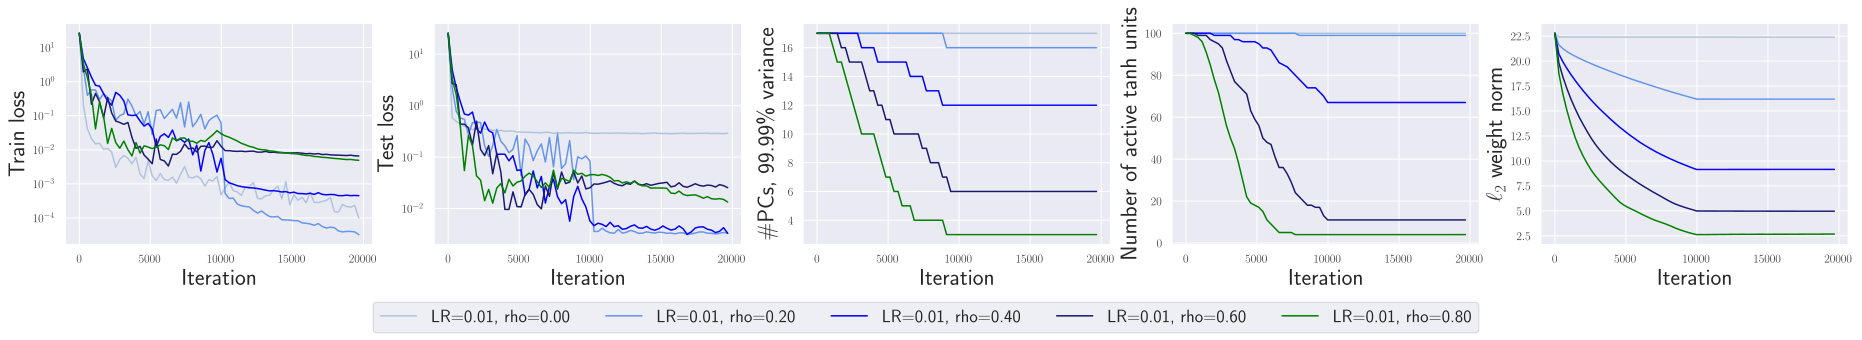

In [117]:
### SGD with tanh activation
hps = {
    'lenaic_with_biases_no_alignment': {'n': 20, 'd': 3, 'm_teacher': 3, 'm_student': 100, 'init_scales_teacher': [1.0, 1.0], 'init_scales_student': [1.0, 1.0], 'seed': 4, 'gamma': 0.455, 'warmup_mult_factor': 1.0},  # note: modified the init_scales_student to get away from rank=4 (linear regime of tanh)
}

exp = 'lenaic_with_biases_no_alignment' 
act = 'tanh'
biases = True
X, y, X_test, y_test, net_teacher = get_data_two_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'], biases=biases, act=act)
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.3, x_log_scale=x_log_scale, n_iters_first=1, n_iters_next=71)  # 4.15

n_plots = 5
lp = 0.1
l0_threshold = 0.1
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001
percentile_pcs = 0.9999
nnz_threshold = 0.05

gamma, batch_size = 0.005, 1  # SAM requires lowering the step size a bit
schedule_length, decay_factor = 0.5, 1.0  
rhos = [0.0, 0.2, 0.4, 0.6, 0.8]
rho_duration = schedule_length
sam_grad_normalization = True

nets_all = []
plt.figure(figsize = (32, 4))  # (12, 4) for 2 plots, (22, 4) for 3 plots, (26, 4) for 4 plots, (32, 4) for 5 plots
for i, rho in enumerate(rhos):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet2Layers(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student'], biases=[biases, biases], act=act) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], rho=rho, rho_duration=rho_duration, sam_grad_normalization=sam_grad_normalization) 
    nets_all.append(nets)
    lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1]**lp).sum() for net in nets]
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer1.bias.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2) + np.sum(net.layer2.bias.data.numpy()**2))**0.5 for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    feature_ranks = np.array([compute_n_pcs(compute_feature_sing_values(net, X), percentile_pcs) for net in nets])
    n_nnz_acts = [((np.abs(net.features(X)) < nnz_threshold).sum(0) < X.shape[0]).sum() for net in nets]
    n_distinct_relus = [hps[exp]['m_student'] - net.n_highly_corr(X, corr_threshold=0.999) for net in nets]

    print('batch_size={}, rho={:.2f}: train loss {}, test loss {}, l2_param {}, feature rank {}, n nnz neurons {}, n distinct neurons {}'.format(batch_size, rho, train_losses[-1], test_losses[-1], l2_norms[-1], feature_ranks[-1], n_nnz_acts[-1], n_distinct_relus[-1]))

    label = 'LR={:.2f}, rho={:.2f}'.format(gamma, rho)

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, feature_ranks, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('\#PCs, {:.2f}\% variance'.format(percentile_pcs*100), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, n_nnz_acts, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Number of active tanh units', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 5)
    plt.plot(iters_loss, l2_norms, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$\ell_2$ weight norm', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.22), ncol=7, prop={'size': legend_size})
plt.savefig("plots/fc_net_d={}_exp={}_lp={}_act={}.pdf".format(hps[exp]['d'], exp, lp, act), bbox_inches='tight')
plt.show()

y tensor([-0.4467, -0.8946,  0.2728,  0.2902, -0.8578, -0.2734, -1.2403, -0.3220,
        -0.4219,  0.0389,  0.1291,  0.1257, -0.7623, -0.9629,  0.5595, -0.3819,
         0.3070,  0.4649,  0.3832, -0.2585])
batch_size=1, rho=0.00: train loss 3.7757647532998817e-06, test loss 0.014712484553456306, l2_param 6.249424411972436, feature rank 19, n nnz neurons 77, n distinct neurons 75
batch_size=1, rho=0.10: train loss 1.5541263564955443e-06, test loss 0.008914725854992867, l2_param 7.1448798994003715, feature rank 18, n nnz neurons 68, n distinct neurons 44
batch_size=1, rho=0.20: train loss 6.768603725504363e-06, test loss 0.0060349334962666035, l2_param 8.613440244422566, feature rank 15, n nnz neurons 58, n distinct neurons 25
batch_size=1, rho=0.40: train loss 0.0003277903888374567, test loss 0.01016019657254219, l2_param 10.134657033829974, feature rank 9, n nnz neurons 35, n distinct neurons 14
batch_size=1, rho=0.60: train loss 0.0017745578661561012, test loss 0.008294619619846344, 

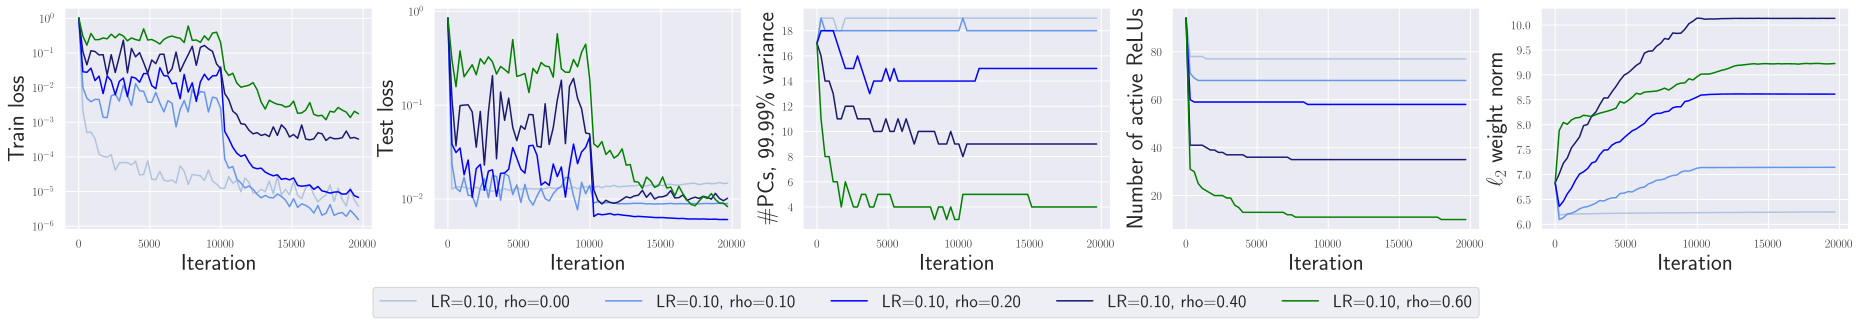

In [119]:
### ReLU network
hps = {
    'lenaic_with_biases_no_alignment': {'n': 20, 'd': 3, 'm_teacher': 3, 'm_student': 100, 'init_scales_teacher': [1.0, 1.0], 'init_scales_student': [0.3, 0.3], 'seed': 4, 'gamma': 0.455, 'warmup_mult_factor': 1.0},
}

exp = 'lenaic_with_biases_no_alignment' 
act = 'relu'
biases = True
X, y, X_test, y_test, net_teacher = get_data_two_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'], biases=biases, act=act)
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.3, x_log_scale=x_log_scale, n_iters_first=1, n_iters_next=71)  # 4.15

n_plots = 5
lp = 0.1
l0_threshold = 0.1
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001
percentile_pcs = 0.9999

gamma, batch_size = 0.1, 1  # SAM requires lowering the step size a bit
schedule_length, decay_factor = 0.5, 1.0  
rhos = [0.0, 0.1, 0.2, 0.4, 0.6]
rho_duration = schedule_length
sam_grad_normalization = True

nets_all = []
plt.figure(figsize = (32, 4))  # (12, 4) for 2 plots, (22, 4) for 3 plots, (26, 4) for 4 plots, (32, 4) for 5 plots
for i, rho in enumerate(rhos):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet2Layers(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student'], biases=[biases, biases], act=act) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], rho=rho, rho_duration=rho_duration, sam_grad_normalization=sam_grad_normalization) 
    nets_all.append(nets)
    lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1]**lp).sum() for net in nets]
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer1.bias.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2) + np.sum(net.layer2.bias.data.numpy()**2))**0.5 for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    feature_ranks = np.array([compute_n_pcs(compute_feature_sing_values(net, X), percentile_pcs) for net in nets])
    n_nnz_relus = [((F.relu(net.layer1(X)) <= 0.0).sum(0) < X.shape[0]).sum() for net in nets]
    n_distinct_relus = [hps[exp]['m_student'] - net.n_highly_corr(X, corr_threshold=0.999) for net in nets]

    print('batch_size={}, rho={:.2f}: train loss {}, test loss {}, l2_param {}, feature rank {}, n nnz neurons {}, n distinct neurons {}'.format(batch_size, rho, train_losses[-1], test_losses[-1], l2_norms[-1], feature_ranks[-1], n_nnz_relus[-1], n_distinct_relus[-1]))

    label = 'LR={:.2f}, rho={:.2f}'.format(gamma, rho)

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, feature_ranks, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('\#PCs, {:.2f}\% variance'.format(percentile_pcs*100), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, n_nnz_relus, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Number of active ReLUs', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 5)
    plt.plot(iters_loss, l2_norms, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$\ell_2$ weight norm', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.22), ncol=7, prop={'size': legend_size})
plt.savefig("plots/fc_net_d={}_exp={}_lp={}_act={}.pdf".format(hps[exp]['d'], exp, lp, act), bbox_inches='tight')
plt.show()

y tensor([-0.4467, -0.8946,  0.2728,  0.2902, -0.8578, -0.2734, -1.2403, -0.3220,
        -0.4219,  0.0389,  0.1291,  0.1257, -0.7623, -0.9629,  0.5595, -0.3819,
         0.3070,  0.4649,  0.3832, -0.2585])
batch_size=1, grad_reg=0.000: train loss 3.7757647532998817e-06, test loss 0.014712484553456306, l2_param 6.249424411972436, feature rank 19, n nnz neurons 77, n distinct neurons 75
batch_size=1, grad_reg=0.100: train loss 6.815530014137039e-06, test loss 0.010421049781143665, l2_param 6.564163433153416, feature rank 18, n nnz neurons 76, n distinct neurons 60
batch_size=1, grad_reg=0.200: train loss 6.005195132274821e-07, test loss 0.0073332404717803, l2_param 7.882342351951553, feature rank 16, n nnz neurons 60, n distinct neurons 33
batch_size=1, grad_reg=0.300: train loss 3.899855073541403e-06, test loss 0.006628402508795261, l2_param 11.331100094240767, feature rank 13, n nnz neurons 39, n distinct neurons 24
batch_size=1, grad_reg=0.350: train loss 7.243485015351325e-06, test 

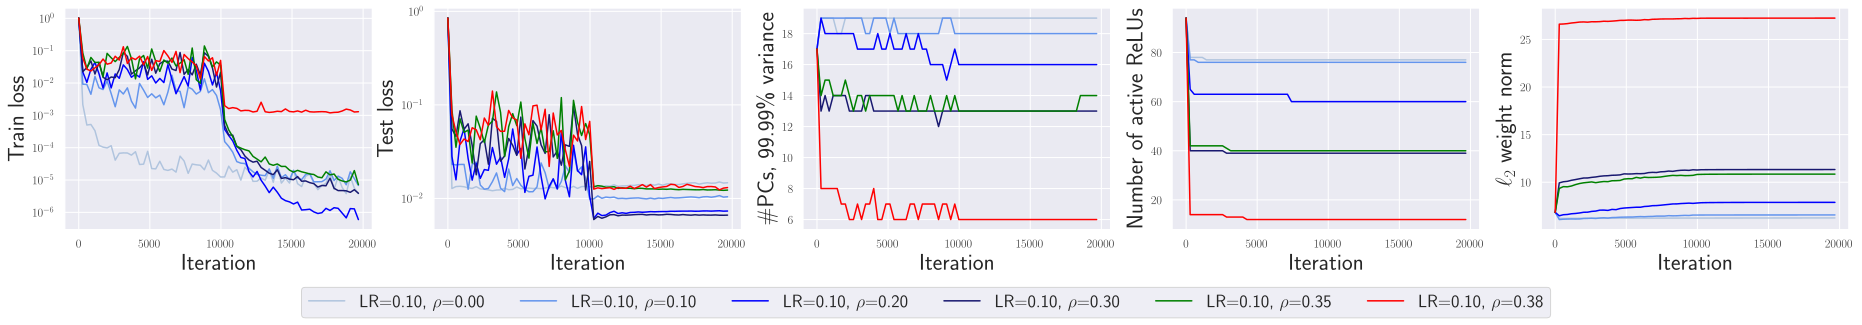

In [116]:
### Gradient regularization
hps = {
    'lenaic_with_biases_no_alignment': {'n': 20, 'd': 3, 'm_teacher': 3, 'm_student': 100, 'init_scales_teacher': [1.0, 1.0], 'init_scales_student': [0.3, 0.3], 'seed': 4, 'gamma': 0.455, 'warmup_mult_factor': 1.0},
}

exp = 'lenaic_with_biases_no_alignment' 
act = 'relu'
biases = True
X, y, X_test, y_test, net_teacher = get_data_two_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'], biases=biases, act=act)
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.3, x_log_scale=x_log_scale, n_iters_first=1, n_iters_next=71)  # 4.15

n_plots = 5
lp = 0.1
l0_threshold = 0.1
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001
percentile_pcs = 0.9999

gamma, batch_size = 0.1, 1  # SAM requires lowering the step size a bit
schedule_length, decay_factor = 0.5, 1.0  
grad_regs = [0.0, 0.1, 0.2, 0.3, 0.35, 0.38]  # final grid for the gradient norm (no square)
rho_duration = schedule_length
grad_reg_duration = schedule_length

nets_all = []
plt.figure(figsize = (32, 4))  # (12, 4) for 2 plots, (22, 4) for 3 plots, (26, 4) for 4 plots, (32, 4) for 5 plots
for i, grad_reg in enumerate(grad_regs):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet2Layers(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student'], biases=[biases, biases], act=act) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], grad_reg=grad_reg, grad_reg_duration=grad_reg_duration) 
    nets_all.append(nets)
    lp_norms_sing = [(np.linalg.svd(net.layer1.weight.data.numpy() * np.abs(net.layer2.weight.data.numpy().T))[1]**lp).sum() for net in nets]
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer1.bias.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2) + np.sum(net.layer2.bias.data.numpy()**2))**0.5 for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    feature_ranks = np.array([compute_n_pcs(compute_feature_sing_values(net, X), percentile_pcs) for net in nets])
    n_nnz_relus = [((F.relu(net.layer1(X)) <= 0.0).sum(0) < X.shape[0]).sum() for net in nets]
    n_distinct_relus = [hps[exp]['m_student'] - net.n_highly_corr(X, corr_threshold=0.999) for net in nets]

    print('batch_size={}, grad_reg={:.3f}: train loss {}, test loss {}, l2_param {}, feature rank {}, n nnz neurons {}, n distinct neurons {}'.format(batch_size, grad_reg, train_losses[-1], test_losses[-1], l2_norms[-1], feature_ranks[-1], n_nnz_relus[-1], n_distinct_relus[-1]))

    label = 'LR={:.2f}, $\\rho$={:.2f}'.format(gamma, grad_reg)

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, feature_ranks, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('\#PCs, {:.2f}\% variance'.format(percentile_pcs*100), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, n_nnz_relus, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Number of active ReLUs', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 5)
    plt.plot(iters_loss, l2_norms, label=label, color=colors[i], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$\ell_2$ weight norm', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.22), ncol=7, prop={'size': legend_size})
plt.savefig("plots/fc_net_d=2_exp={}_lp={}_grad_reg.pdf".format(exp, lp), bbox_inches='tight')
plt.show()